# Load Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data = pd.concat([train_data, test_data])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


# Feature Engineering

In [3]:
def plt_hist_for_feature(feature, bins = None):
    plt.hist([features[data.Survived == 1][feature], features[data.Survived == 0][feature]], stacked = True,
            color = ['g', 'b'], label = ['Survived', 'Dead'], 
            bins = bins if bins != None else features[feature].value_counts().count())
    plt.legend(loc = 'best')
features = pd.DataFrame()

## Title

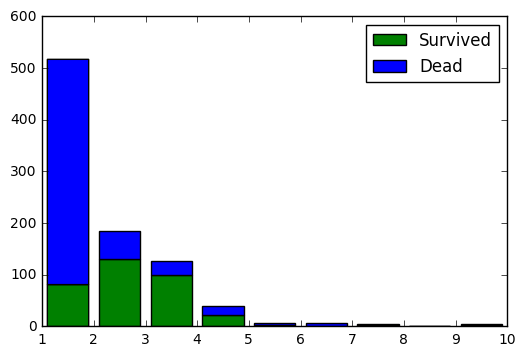

In [4]:
title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7,
             "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "the Countess": 10, "Jonkheer": 10,
             "Sir": 9, "Capt": 7, "Ms": 2}
features['Title'] = data.Name.map(lambda name: title_map[name.split('.')[0].split(',')[1].strip()])
plt_hist_for_feature('Title')

In [5]:
has_name_length = True
if has_name_length:
    features['NameLength'] = data.Name.map(lambda name: len(name))

## Family Size

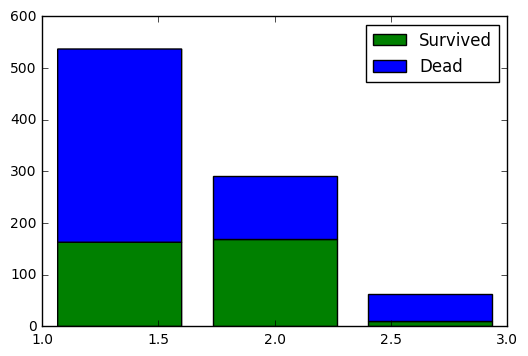

In [6]:
data['FamilySize'] = data.Parch + data.SibSp + 1
features['Parch'] = data.Parch
features['SibSp'] = data.SibSp
features['FamilySizeType'] = pd.cut(data.FamilySize, bins = [0, 1, 4, 20], labels = [1, 2, 3])
plt_hist_for_feature('FamilySizeType')

## Family ID

In [7]:
has_family_id = False
if has_family_id:
    data['Surname'] = data.Name.map(lambda name: name.split(',')[0].strip())
    data['FamilyId'] = data.apply(lambda row: row.Surname + str(row.FamilySize), axis = 1)
    data.loc[data.FamilySize <= 2, 'FamilyId'] = 'Small'
    data.FamilyId = data.FamilyId.fillna('Small')
    family_id_table = data.FamilyId.value_counts()
    family_id_table = pd.DataFrame({'FamilyId' : family_id_table.keys(), 'Size' : family_id_table.values})
    data.FamilyId = data.FamilyId.map(lambda id:
                                      'Small' if (family_id_table[family_id_table.FamilyId == id]['Size'] <= 2).any() else id)
    features['FamilyId'] = pd.factorize(data.FamilyId)[0]
    plt_hist_for_feature('FamilyId', bins = 10)

## Sex

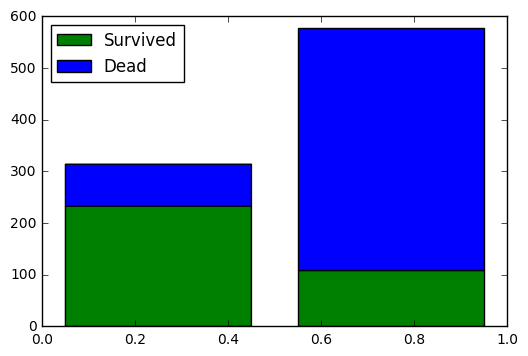

In [8]:
features['Sex'] = data.Sex.map({'female' : 0, 'male' : 1})
plt_hist_for_feature('Sex')

## Pclass

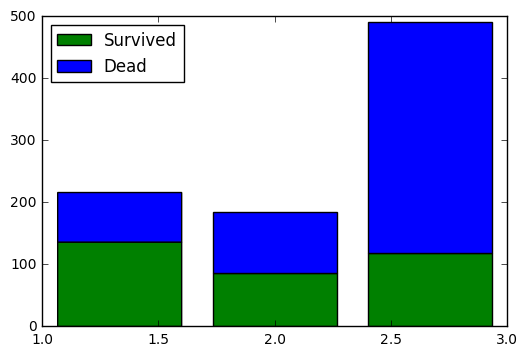

In [9]:
features['Pclass'] = data.Pclass
plt_hist_for_feature('Pclass')

## Fare

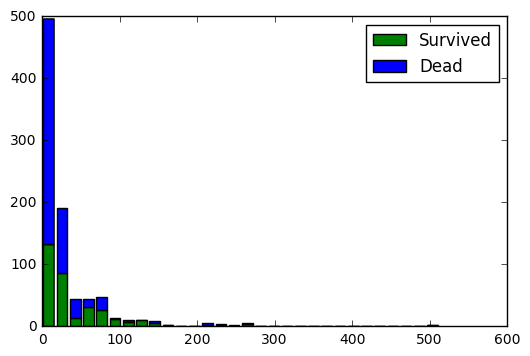

In [10]:
features['Fare'] = data.Fare.fillna(data.Fare.mean())
plt_hist_for_feature('Fare', bins = 30)

## Embarked

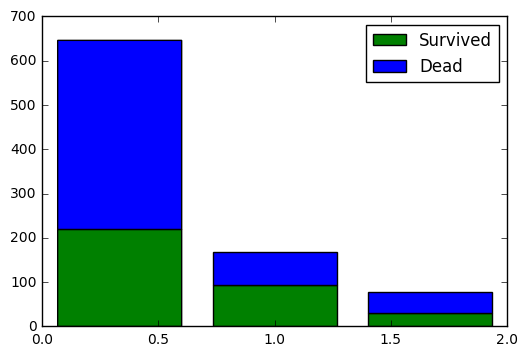

In [11]:
data['Embarked'] = data.Embarked.fillna('S')
features['Embarked'] = pd.factorize(data.Embarked)[0]
plt_hist_for_feature('Embarked')

## Age

[ 0.02149871 -0.06990449  0.03340302 -0.36657084 -0.24229674] -0.124774066138


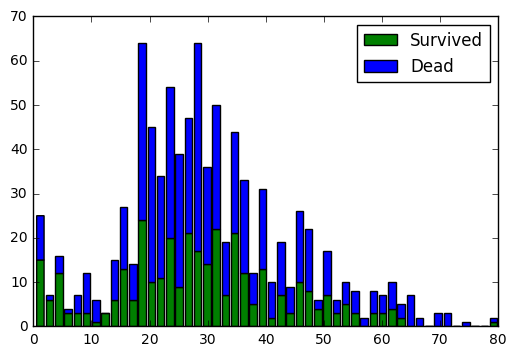

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
learn_age = True
if learn_age:
    features['Age'] = data.Age
    Xtrain_age = features[data.Age.notnull()].copy()
    Xtrain_age = Xtrain_age.drop(['Age'], axis = 1)
    ytrain_age = features[features.Age.notnull()].Age
    regressor = DecisionTreeRegressor()
    score = cross_val_score(regressor, Xtrain_age, ytrain_age, cv = 5)
    print(score, score.mean())
    
    Xtest_age = features[data.Age.isnull()].copy()
    Xtest_age = Xtest_age.drop(['Age'], axis = 1)
    regressor.fit(Xtrain_age, ytrain_age)
    ages = regressor.predict(Xtest_age)
    features.loc[features.Age.isnull(), 'Age'] = ages
else:
    features['Age'] = data.Age.fillna(data.Age.median())
plt_hist_for_feature('Age', bins = 50)

In [13]:
has_age_type = True
if has_age_type:
    data['AgeType'] = features.apply(lambda row: 1 if row.Age < 18 else 2 if row.Sex == 0 else 3, axis = 1)
    features = pd.concat([features, pd.get_dummies(data.AgeType, prefix = 'AgeType')], axis = 1)

## Cabin

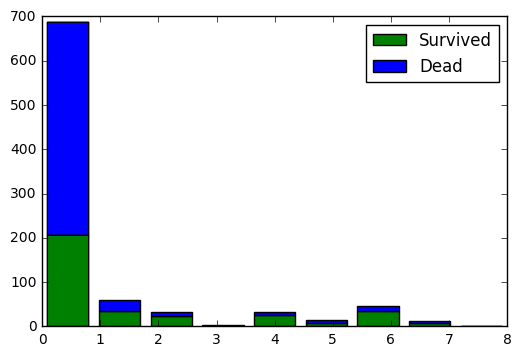

In [14]:
data['Cabin'] = data.Cabin.fillna('0')
features['Cabin'] = pd.factorize(data.Cabin.map(lambda cabin: cabin[0]))[0]
plt_hist_for_feature('Cabin')

# Modeling

## Feature Selection

In [15]:
Xtrain = features[:train_data.PassengerId.count()]
ytrain = train_data.Survived
Xtest = features[train_data.PassengerId.count():]

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
extra_classifier = ExtraTreesClassifier(n_estimators = 200)
extra_classifier.fit(Xtrain, ytrain)
importances = pd.DataFrame()
importances['FeatureName'] = Xtrain.columns
importances['Importance'] = extra_classifier.feature_importances_
importances.sort_values('Importance', ascending = False)

,FeatureName,Importance
9,Age,0.139243
7,Fare,0.135221
1,NameLength,0.133860
5,Sex,0.112382
12,AgeType_3,0.105957
6,Pclass,0.086719
11,AgeType_2,0.057020
13,Cabin,0.049857
4,FamilySizeType,0.043359
0,Title,0.041238


In [17]:
from sklearn.feature_selection import SelectFromModel
select_model = SelectFromModel(extra_classifier, prefit = True)
Xtrain_selected = select_model.transform(Xtrain)
Xtest_selected = select_model.transform(Xtest)
Xtrain_selected.shape, Xtest_selected.shape, select_model

((891, 6),
 (418, 6),
 SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
         prefit=True, threshold=None))

## Parameters Tuning

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

random_forest = RandomForestClassifier()
parameter_grid = {'max_features' : [None, 'sqrt', 'log2'],
                  'max_depth' : [4, 5, 6, 7, 8], 
                  'n_estimators' : [200, 250, 500],
                  # 'n_estimators' : [200, 250, 500, 1000, 2000],
                  'criterion' : ['gini', 'entropy']}
grid_search = GridSearchCV(random_forest, param_grid = parameter_grid)
grid_search.fit(Xtrain, ytrain)
print('Best Score: {}'.format(grid_search.best_score_))
print('Best Parameter: {}'.format(grid_search.best_params_))

Best Score: 0.8372615039281706
Best Parameter: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 250, 'max_features': None}


## Predict

In [19]:
survived = grid_search.predict(Xtest)
predict_data = pd.DataFrame()
predict_data['PassengerId'] = test_data.PassengerId
predict_data['Survived'] = survived.astype(int)
predict_data.to_csv('predict.csv', index = False)
survived.sum(), len(survived)

(150, 418)

## Cross Validation

In [20]:
random_forest = RandomForestClassifier(n_estimators = 3000, min_samples_split = 4)
score = cross_val_score(random_forest, Xtrain, ytrain, cv = 5)
print(score)
print(score.mean())

[ 0.84916201  0.79888268  0.8258427   0.81460674  0.85875706]
0.829450238617


In [21]:
random_forest.fit(Xtrain, ytrain)
survived = random_forest.predict(Xtest)
predict_data = pd.DataFrame()
predict_data['PassengerId'] = test_data.PassengerId
predict_data['Survived'] = survived.astype(int)
predict_data.to_csv('predict_validation.csv', index = False)
survived.sum(), len(survived)

(148, 418)